In [1]:
from collections import defaultdict
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import gc

# Global Variables

In [247]:
timeout = 10 ** 5
threshold = 0.001

# State Spaces

In [248]:
class StateSpace:
    def __init__(self, start):
        self.start = start
        self.validate = 1000
        
    def actions(self, state):
        raise NotImplementedError
        
    def rewards(self, state, action, next_state, time):
        raise NotImplementedError
    
    def next_state(self, state, action, time):
        raise NotImplementedError
    
    def transition(self, state, action, time):
        next_state = self.next_state(state, action, time)
        return self.rewards(state, action, next_state, time), next_state

## Trivial (Action-Agnostic)

In [274]:
class Trivial(StateSpace):
    def __init__(self, start = 0, transition = [[0, 1], [1, 0]], rewards = [0.4, 0.6]):
        super().__init__(0)

        self.phi, self.t = 0, transition
        self.expectations = rewards
        
    def actions(self, state):
        return [ "Recieve" ]
    
    def rewards(self, state, action, next_state, time):
        reward = 1 * ( np.random.uniform(0, 1) < self.expectations[self.phi] )
        return reward
    
    def next_state(self, state, action, time):
        self.phi = np.random.choice(len(self.expectations), p = self.t[self.phi])
        return 0

## Gridworlds

In [250]:
directions = {
    "u": ( 1, 0),
    "d": (-1, 0),
    "r": (0,  1),
    "l": (0, -1)
}

class GridWorld(StateSpace):
    def __init__(self, start = (0, 0), edges = 25, density = 5):
        super().__init__(start)
        self.edges = edges
        self.density = density
        self.validate = self.edges ** 4
        
    def actions(self, state):
        return [ "u", "d", "r", "l" ]
        
    def rewards(self, state, action, next_state, time):
        x, y = next_state
        return (x + y) / 2 if (x + y) % 10 < self.density else 0
    
    def next_state(self, state, action, time):
        return tuple(map( lambda x, y: (x + y) % self.edges, state, directions[action] ))

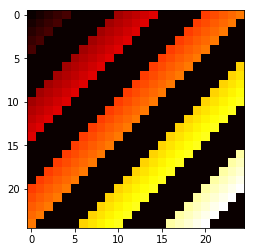

In [251]:
heatmap = [[ (x + y) / 2 if (x + y) % 10 < 5 else 0 for x in range(25) ] for y in range(25) ]

plt.imshow( heatmap, cmap = "hot" )
plt.show()

In [252]:
def linear(x, y, time, regime):
    return regime, time

def independent(x, y, time, regime):
    return regime, abs(x - y) * time * 0.001

def n_state(n, M, Q):
    def dynamics(x, y, time, regime):
        d = np.eye(1, n, regime)
        next_state = np.random.choice(n, p = d.dot(M))
        return next_state, Q[next_state]
    return dynamics

class NonStationary(GridWorld):
    def __init__(self, start = (0, 0), edges = 25, density = 2, dynamic = linear):
        self.regime, self.dynamics = 0, dynamic
        super().__init__(start, edges, density)
        
    def rewards(self, state, action, next_state, time):
        self.regime, trend = self.dynamics(* state, time, self.regime)
        return super().rewards(state, action, next_state, time) + trend

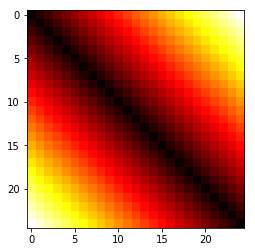

In [253]:
heatmap = [[ abs(x - y) for x in range(25) ] for y in range(25) ]

plt.imshow( heatmap, cmap = "hot" )
plt.show()

## N-Armed Bandit

In [254]:
class BanditTask(StateSpace):
    def __init__(self, start = 0, correct = 0, n = 2):
        super().__init__(start)
        
        self.correct = 0
        self.switch  = np.random.randint(7, 24)
        self.N = n
        self.validate = (n * 24) ** 2
        
    def actions(self, state):
        return list( range(self.N) )
        
    def rewards(self, state, action, next_state, time):
        return 1 * (action == self.correct)
    
    def next_state(self, state, action, time):
        self.switch = self.switch - 1
        if self.switch == 0:
            self.correct = np.random.randint( self.N )
            self.switch  = np.random.randint(7, 24)
        return state

# Agents

In [255]:
class agent:
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5 ):
        self.q_vals, self.v_vals = defaultdict(lambda: np.random.random()), defaultdict(lambda: 0)
        
        self.alpha, self.epsilon, self.discount = alpha, epsilon, discount
        if action_selection:
            self.action_selection = action_selection
 
    def max_action(self, state, time):
        return max(self.space.actions(state), key = lambda x: self.q_value(state, x, time))

    def action_selection(self, state, time):
        return self.max_action(state, time)
    
    def q_value(self, state, action, time):
        return self.q_vals[(state, action)]
    
    def update(self, state, next_state, action, reward, time):
        max_q_val  = self.q_vals[( next_state, self.max_action(state, time) )]
        previous = self.q_vals[(state, action)]
        
        self.q_vals[(state, action)] = (1 - self.alpha) * previous + self.alpha * (reward + self.discount * (max_q_val))
        self.v_vals[state] = self.v_vals[state] + 1
        
        delta = self.q_vals[(state, action)] - previous
        return np.average(delta)
        
    def play(self, space):  
        time, state = 0, space.start
        self.space = space
        
        TDEs = []
        while (self.alpha > 0.01) and (time < timeout):
            action = self.action_selection(self, state, time)
            reward, next_state = self.space.transition(state, action, time)

            delta = self.update(state, next_state, action, reward, time)
            TDEs.append( abs(delta) )
            
            self.alpha = ( self.alpha * 0.999 ) if abs(delta) < threshold else min( self.alpha * 1.001, 1.0 )
            state, time = next_state, time + 1
            
        return self.validate(), time, TDEs
    
    def validate(self):
        print(self.q_vals)
        average_reward, state = 0, self.space.start
        for p in range( self.space.validate ):
            reward, state = self.space.transition(state, self.max_action(state, p), p)
            average_reward = average_reward + reward
        return average_reward / p

In [256]:
def steady_state(Q):
    a, b = np.linalg.eig(Q)
    eige = b.T[ list(a).index(1) ]
    return eige / sum(eige)

In [257]:
class posterior_agent(agent):
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5, \
                  dynamics = [[0, 1], [1, 0]] ):
        super().__init__(action_selection, alpha, discount, epsilon)

        self.dynamics, self.n  = np.array( dynamics ), len(dynamics)
        self.pdf = steady_state( self.dynamics )
        
        self.q_vals = defaultdict(lambda: np.random.random(( self.n, )))
        
    def get_posterior(self, state, action, reward):
        posterior = self.q_vals[(state, action)] if reward else abs(1 - self.q_vals[(state, action)])
        posterior = posterior * self.pdf
        return posterior / sum(posterior)
    
    def q_value(self, state, action, time):
        return np.sum( super().q_value( state, action, time ) * self.pdf )
    
    def update(self, state, next_state, action, reward, time):
        reward = self.get_posterior(state, action, reward) * reward
        return super().update( state, next_state, action, reward, time )

Despite the name, particle agent uses an algorithm closer to likelihood-weighted sampling. See Russell, Norvig 2015 for the distinction

In [276]:
class particle_agent(agent):
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5, \
                  dynamics = [[0, 1], [1, 0]] ):
        super().__init__(action_selection, alpha, discount, epsilon)
        self.q_vals = defaultdict(lambda: np.ones(( self.n, )) / self.n)

        self.dynamics, self.n  = np.array( dynamics ), len(dynamics)
        self.pdf = steady_state( self.dynamics )
        
        self.particles = np.random.random(( self.n, ))
        self.particles = self.particles / np.sum(self.particles)
        
    def update_particles(self, state, action, reward):
        posterior = self.q_vals[(state, action)] if reward else 1 - self.q_vals[(state, action)]        
        posterior = posterior * self.pdf

        self.particles = self.dynamics.dot( self.particles ) * posterior
        self.particles = self.particles / np.sum(self.particles)
        
        return np.random.choice( self.n, p = self.particles )
    
    def q_value(self, state, action, time):
        return super().q_value( state, action, time )[ np.argmax( self.particles ) ]
    
    def update(self, state, next_state, action, reward, time):
        reward_vec = np.zeros(( self.n, )) if reward else np.ones(( self.n, ))
        reward_vec[ self.update_particles(state, action, reward) ] = reward

        reward_vec = reward_vec / sum(reward_vec)
        return super().update( state, next_state, action, reward_vec, time)

### Demonstration plot for pseudo-online estimation of HMM dynamics

In [383]:
def random_matrix(size):
    matrix = np.random.random((size, size))
    matrix = matrix / np.sum(a_p, axis = 0)
    return matrix

def initial_setup(size, trials, samples):
    matrix = random_matrix(size)
    
    vector = np.random.random(( size, ))
    vector = vector / sum(vector)
    return matrix, vector, \
           [ np.linalg.matrix_power(matrix, i).dot(vector) for i in range(trials) ], \
           [ random_matrix(size) for i in range(samples) ]

In [395]:
def minimizer(sample, vector, history):
    v = [ np.linalg.matrix_power(sample, i).dot(vector) for i in range( len(history) ) ]
    v = [ np.linalg.norm(v[i] - history[i]) for i in range( len(v) ) ]
    return sum(v)

def run_test(size, trials, number_samples):
    matrix, vector, history, samples = initial_setup(size, trials, number_samples)
    best_fit = min( samples, key = lambda x: minimizer(x, vector, history) )
    return np.linalg.norm( matrix - best_fit )

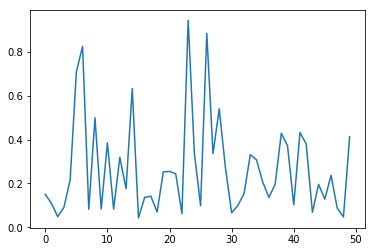

In [398]:
plt.plot( range(50), [ run_test(2, 20, 10000) for x in tqdm(range(50)) ] )
plt.show()

In [ ]:
class particle_agent(agent):
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5, n = 2):
        super().__init__(action_selection, alpha, discount, epsilon)
        self.q_vals = defaultdict(lambda: np.ones(( self.n, )) / self.n)

        self.n = n
        
        self.particles = np.random.random(( self.n, ))
        self.particles = self.particles / np.sum(self.particles)
        
    def update_particles(self, state, action, reward):
        posterior = self.q_vals[(state, action)] if reward else 1 - self.q_vals[(state, action)]        
        posterior = posterior * self.pdf

        self.particles = self.dynamics.dot( self.particles ) * posterior
        self.particles = self.particles / np.sum(self.particles)
        
        return np.random.choice( self.n, p = self.particles )
    
    def q_value(self, state, action, time):
        return super().q_value( state, action, time )[ np.argmax( self.particles ) ]
    
    def update(self, state, next_state, action, reward, time):
        reward_vec = np.zeros(( self.n, )) if reward else np.ones(( self.n, ))
        reward_vec[ self.update_particles(state, action, reward) ] = reward

        reward_vec = reward_vec / sum(reward_vec)
        return super().update( state, next_state, action, reward_vec, time)

In [259]:
class linear_agent(agent): 
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5 ):
        super().__init__(action_selection, alpha, discount, epsilon)
        self.xis, self.last = defaultdict(lambda: 0), defaultdict(lambda: (0,0))
     
    def update_xi(self, state, action, reward, time):
        previous, timestamp = self.last[(state, action)]
        
        if self.v_vals[state] > 0:
            change = (reward - previous) / (time - timestamp)
            self.xis[(state, action)] = (self.alpha * change) + (1 - self.alpha) * self.xis[(state, action)]
        
        self.last[(state, action)] = (reward, time)
        return reward - ( self.xis[(state, action)] * time )
    
    def q_value(self, state, action, time):
        return super().q_value(state, action, time) + self.xis[(state, action)] * time
    
    def update(self, state, next_state, action, reward, time):
        reward = self.update_xi(state, action, reward, time)
        return super().update(state, next_state, action, reward, time)

In [260]:
def epsilon_greedy(self, state, time, epsilon = None):
    max_action = max(self.space.actions(state), key = lambda x: self.q_value(state, x, time))
    return max_action if np.random.random() < (epsilon or self.epsilon) else np.random.choice( self.space.actions(state) )

def softmax(self, state, time, beta = 1):
    q_vals = np.array([ self.q_value(state, a, time) for a in self.space.actions(state) ])
    q_vals = q_vals - max(q_vals)
    
    softmax = np.exp((q_vals * beta)) / ( np.sum(np.exp(q_vals * beta)) )
    return np.random.choice( self.space.actions(state), p = softmax )

def boltzmann(self, state, time, epsilon = None):
    return softmax(self, state, time, (epsilon or self.epsilon))
    
def mixture(self, state, time, epsilon = None):
    return softmax(self, state, time) if np.random.random() < (epsilon or self.epsilon) else np.random.choice( self.space.actions(state) )

action_selection_strategies = { "Epsilon-Greedy": epsilon_greedy, "Boltzmann": boltzmann, "Mixture Model": mixture }

# Trials

In [261]:
def plot_convergence(space, _agent = agent, plot_title = ""):
    for title, strategy in action_selection_strategies.items():
        r, i, t = _agent( strategy ).play( space )
        
        plt.plot( range(i), t, label = title + " -- E[R]: " + str(round(r, 3)) )
        plt.legend()
        
    plt.title( plot_title )
    plt.show()

[0.48180523 0.51819477]
[0.4685766 0.5314234]
[0.62727201 0.37272799]
[0.51467073 0.48532927]
[0.31822648 0.68177352]
[0.47770693 0.52229307]
[0.38733858 0.61266142]
[0.68723217 0.31276783]
[0.22266999 0.77733001]
[0.65242547 0.34757453]
[0.27109668 0.72890332]
[0.75835212 0.24164788]
[0.18920288 0.81079712]
[0.7268509 0.2731491]
[0.33220836 0.66779164]
[0.76548225 0.23451775]
[0.27461879 0.72538121]
[0.71915563 0.28084437]
[0.24907578 0.75092422]
[0.81929803 0.18070197]
[0.11809862 0.88190138]
[0.94341682 0.05658318]
[0.13937872 0.86062128]
[0.78719945 0.21280055]
[0.12230214 0.87769786]
[0.95193273 0.04806727]
[0.08806846 0.91193154]
[0.96004358 0.03995642]
[0.10454433 0.89545567]
[0.94317071 0.05682929]
[0.02968195 0.97031805]
[0.98213695 0.01786305]
[0.01017116 0.98982884]
[0.99587315 0.00412685]
[0.01225731 0.98774269]
[0.9785963 0.0214037]
[0.03172753 0.96827247]
[0.96464651 0.03535349]
[0.03813334 0.96186666]
[0.96652834 0.03347166]
[0.02549272 0.97450728]
[0.98517311 0.01482689

[1.0000000e+00 8.1139744e-12]
[1.96550917e-11 1.00000000e+00]
[1.00000000e+00 3.28159691e-11]
[2.30773061e-11 1.00000000e+00]
[1.00000000e+00 3.64575008e-11]
[5.32712475e-11 1.00000000e+00]
[1.00000000e+00 4.36172525e-11]
[3.31848928e-11 1.00000000e+00]
[1.00000000e+00 4.85997472e-11]
[3.84849744e-11 1.00000000e+00]
[1.00000000e+00 2.50027838e-11]
[1.59750478e-11 1.00000000e+00]
[1.0000000e+00 7.9661579e-12]
[1.81531521e-11 1.00000000e+00]
[1.00000000e+00 9.97595482e-12]
[2.06597599e-11 1.00000000e+00]
[1.00000000e+00 3.10991063e-11]
[4.30720526e-11 1.00000000e+00]
[1.00000000e+00 4.86715153e-11]
[4.8954543e-11 1.0000000e+00]
[1.00000000e+00 5.49245235e-11]
[5.40905074e-11 1.00000000e+00]
[1.00000000e+00 6.37902423e-11]
[6.40282605e-11 1.00000000e+00]
[1.00000000e+00 5.53433571e-11]
[4.39617305e-11 1.00000000e+00]
[1.00000000e+00 6.16634174e-11]
[5.06768678e-11 1.00000000e+00]
[1.00000000e+00 3.45236679e-11]
[5.78905718e-11 1.00000000e+00]
[1.0000000e+00 7.5287463e-11]
[8.82288501e-11 

[1.01082026e-19 1.00000000e+00]
[1.0000000e+00 6.9610624e-20]
[1.11191037e-19 1.00000000e+00]
[1.00000000e+00 7.94157744e-20]
[1.22396207e-19 1.00000000e+00]
[1.00000000e+00 9.03645521e-20]
[6.5714616e-20 1.0000000e+00]
[1.00000000e+00 4.00859305e-20]
[7.20590063e-20 1.00000000e+00]
[1.00000000e+00 4.60832269e-20]
[3.00319557e-20 1.00000000e+00]
[1.00000000e+00 4.94543463e-20]
[3.35487048e-20 1.00000000e+00]
[1.00000000e+00 5.31228539e-20]
[3.73753506e-20 1.00000000e+00]
[1.00000000e+00 2.18976528e-20]
[4.09233597e-20 1.00000000e+00]
[1.00000000e+00 2.52212147e-20]
[4.4841377e-20 1.0000000e+00]
[1.00000000e+00 2.89312709e-20]
[1.89955326e-20 1.00000000e+00]
[1.00000000e+00 1.02116537e-20]
[2.07591389e-20 1.00000000e+00]
[1.00000000e+00 3.24099563e-20]
[4.96523752e-20 1.00000000e+00]
[1.00000000e+00 6.30965244e-20]
[5.45683659e-20 1.00000000e+00]
[1.00000000e+00 6.82215046e-20]
[5.99109875e-20 1.00000000e+00]
[1.00000000e+00 7.37907677e-20]
[6.57162543e-20 1.00000000e+00]
[1.00000000e+0

[1.00000000e+00 1.15441501e-22]
[7.85447084e-23 1.00000000e+00]
[1.00000000e+00 4.50454946e-23]
[2.74579082e-23 1.00000000e+00]
[1.00000000e+00 1.36990819e-23]
[2.94022746e-23 1.00000000e+00]
[1.00000000e+00 1.54373326e-23]
[8.80225963e-24 1.00000000e+00]
[1.00000000e+00 1.62566866e-23]
[9.64843404e-24 1.00000000e+00]
[1.00000000e+00 4.65346147e-24]
[1.03242709e-23 1.00000000e+00]
[1.00000000e+00 5.25274217e-24]
[2.92577274e-24 1.00000000e+00]
[1.00000000e+00 1.30002318e-24]
[6.54528591e-25 1.00000000e+00]
[1.00000000e+00 1.36554717e-24]
[3.07676274e-24 1.00000000e+00]
[1.00000000e+00 1.54205014e-24]
[3.29160494e-24 1.00000000e+00]
[1.00000000e+00 1.73422322e-24]
[3.52273287e-24 1.00000000e+00]
[1.00000000e+00 5.64098485e-24]
[3.82772012e-24 1.00000000e+00]
[1.00000000e+00 5.95579708e-24]
[4.15266304e-24 1.00000000e+00]
[1.00000000e+00 6.29118555e-24]
[4.49882136e-24 1.00000000e+00]
[1.00000000e+00 6.64844772e-24]
[4.86753134e-24 1.00000000e+00]
[1.0000000e+00 3.0658083e-24]
[2.0107308

[1.0000000e+00 2.2808802e-32]
[1.35599347e-32 1.00000000e+00]
[1.00000000e+00 6.67858002e-33]
[3.68163153e-33 1.00000000e+00]
[1.00000000e+00 1.64387305e-33]
[8.42067628e-34 1.00000000e+00]
[1.00000000e+00 3.41282449e-34]
[8.83538051e-34 1.00000000e+00]
[1.00000000e+00 1.72362788e-33]
[9.46481788e-34 1.00000000e+00]
[1.00000000e+00 1.78802522e-33]
[3.68185537e-33 1.00000000e+00]
[1.0000000e+00 1.9448261e-33]
[3.86768406e-33 1.00000000e+00]
[1.00000000e+00 2.11141657e-33]
[1.25899399e-33 1.00000000e+00]
[1.0000000e+00 6.2290667e-34]
[1.32164143e-33 1.00000000e+00]
[1.00000000e+00 6.78220409e-34]
[3.85890186e-34 1.00000000e+00]
[1.00000000e+00 1.79709267e-34]
[4.04862799e-34 1.00000000e+00]
[1.00000000e+00 7.16157998e-34]
[4.31541738e-34 1.00000000e+00]
[1.00000000e+00 2.16508901e-34]
[1.2112872e-34 1.0000000e+00]
[1.00000000e+00 2.24519615e-34]
[4.52054322e-34 1.00000000e+00]
[1.00000000e+00 2.43620573e-34]
[4.74572697e-34 1.00000000e+00]
[1.00000000e+00 7.55268255e-34]
[5.03602584e-34 

[1.01591317e-57 1.00000000e+00]
[1.0000000e+00 1.3028048e-57]
[1.70659391e-57 1.00000000e+00]
[1.00000000e+00 2.04914841e-57]
[2.47514779e-57 1.00000000e+00]
[1.00000000e+00 2.13143005e-57]
[1.84011805e-57 1.00000000e+00]
[1.00000000e+00 1.47991152e-57]
[1.21075387e-57 1.00000000e+00]
[1.00000000e+00 9.10893953e-58]
[1.2511389e-57 1.0000000e+00]
[1.00000000e+00 9.49570325e-58]
[7.42342558e-58 1.00000000e+00]
[1.00000000e+00 5.27788178e-58]
[3.92023492e-58 1.00000000e+00]
[1.00000000e+00 2.61436978e-58]
[1.84719391e-58 1.00000000e+00]
[1.00000000e+00 1.15683719e-58]
[1.90540809e-58 1.00000000e+00]
[1.00000000e+00 1.21048569e-58]
[8.2362335e-59 1.0000000e+00]
[1.00000000e+00 4.91839035e-59]
[8.49201565e-59 1.00000000e+00]
[1.00000000e+00 1.26287429e-58]
[1.98986435e-58 1.00000000e+00]
[1.00000000e+00 2.75922046e-58]
[3.98556691e-58 1.00000000e+00]
[1.00000000e+00 5.16787189e-58]
[6.87004755e-58 1.00000000e+00]
[1.00000000e+00 5.37984079e-58]
[4.31250987e-58 1.00000000e+00]
[1.00000000e+0

[0.47194198 0.52805802]
[0.47843324 0.52156676]
[0.52602582 0.47397418]
[0.52691901 0.47308099]
[0.37140657 0.62859343]
[0.58844049 0.41155951]
[0.42545969 0.57454031]
[0.63803849 0.36196151]
[0.27329641 0.72670359]
[0.60021853 0.39978147]
[0.48965119 0.51034881]
[0.39137694 0.60862306]
[0.67348812 0.32651188]
[0.24306547 0.75693453]
[0.63772008 0.36227992]
[0.57521863 0.42478137]
[0.23760745 0.76239255]
[0.54155558 0.45844442]
[0.30105683 0.69894317]
[0.79234714 0.20765286]
[0.34418401 0.65581599]
[0.58084754 0.41915246]
[0.30855903 0.69144097]
[0.75135286 0.24864714]
[0.1799373 0.8200627]
[0.90203681 0.09796319]
[0.05051657 0.94948343]
[0.88895327 0.11104673]
[0.06640856 0.93359144]
[0.87365572 0.12634428]
[0.08489511 0.91510489]
[0.85588256 0.14411744]
[0.10624704 0.89375296]
[0.83538302 0.16461698]
[0.09297088 0.90702912]
[0.96420299 0.03579701]
[0.11009565 0.88990435]
[0.73709119 0.26290881]
[0.47605566 0.52394434]
[0.7718521 0.2281479]
[0.14183473 0.85816527]
[0.7456759 0.2543241

[2.09141371e-11 1.00000000e+00]
[1.0000000e+00 2.4717463e-11]
[2.59270847e-11 1.00000000e+00]
[1.00000000e+00 2.38721955e-11]
[1.86617182e-11 1.00000000e+00]
[1.00000000e+00 1.37560033e-11]
[2.06965407e-11 1.00000000e+00]
[1.0000000e+00 2.8769628e-11]
[2.45121498e-11 1.00000000e+00]
[1.00000000e+00 1.92969238e-11]
[1.25046203e-11 1.00000000e+00]
[1.00000000e+00 2.19666835e-11]
[2.95978662e-11 1.00000000e+00]
[1.00000000e+00 3.62358567e-11]
[3.75152016e-11 1.00000000e+00]
[1.00000000e+00 3.37556029e-11]
[4.32029069e-11 1.00000000e+00]
[1.00000000e+00 3.96749223e-11]
[4.9786806e-11 1.0000000e+00]
[1.00000000e+00 4.65528942e-11]
[3.93752841e-11 1.00000000e+00]
[1.00000000e+00 5.18612021e-11]
[6.19278676e-11 1.00000000e+00]
[1.00000000e+00 6.30021566e-11]
[6.96210034e-11 1.00000000e+00]
[1.00000000e+00 6.77435055e-11]
[8.0368765e-11 1.0000000e+00]
[1.00000000e+00 7.90900178e-11]
[6.96005024e-11 1.00000000e+00]
[1.00000000e+00 5.17267255e-11]
[7.93763181e-11 1.00000000e+00]
[1.00000000e+00 

[2.99996969e-29 1.00000000e+00]
[1.00000000e+00 5.05934875e-29]
[8.58726489e-29 1.00000000e+00]
[1.00000000e+00 5.72424231e-29]
[9.35353971e-29 1.00000000e+00]
[1.00000000e+00 6.45915513e-29]
[4.49396827e-29 1.00000000e+00]
[1.00000000e+00 2.61747181e-29]
[4.88138461e-29 1.00000000e+00]
[1.00000000e+00 2.97843884e-29]
[1.88542086e-29 1.00000000e+00]
[1.00000000e+00 9.75254167e-30]
[5.44819702e-30 1.00000000e+00]
[1.00000000e+00 1.03591228e-29]
[6.07832767e-30 1.00000000e+00]
[1.00000000e+00 1.10136911e-29]
[2.0422947e-29 1.0000000e+00]
[1.00000000e+00 1.25147998e-29]
[7.95222587e-30 1.00000000e+00]
[1.00000000e+00 4.13593589e-30]
[2.32119071e-30 1.00000000e+00]
[1.00000000e+00 1.02945686e-30]
[2.51058882e-30 1.00000000e+00]
[1.00000000e+00 4.50229822e-30]
[2.78725226e-30 1.00000000e+00]
[1.00000000e+00 1.40304312e-30]
[3.01718403e-30 1.00000000e+00]
[1.00000000e+00 4.95680111e-30]
[3.3304577e-30 1.0000000e+00]
[1.00000000e+00 1.86020691e-30]
[1.10243257e-30 1.00000000e+00]
[1.00000000e

[1.00000000e+00 2.54781635e-48]
[2.46699545e-48 1.00000000e+00]
[1.00000000e+00 2.67434349e-48]
[2.77483254e-48 1.00000000e+00]
[1.00000000e+00 2.71896072e-48]
[2.91301884e-48 1.00000000e+00]
[1.00000000e+00 2.86047761e-48]
[3.05794296e-48 1.00000000e+00]
[1.00000000e+00 3.12038956e-48]
[3.01878783e-48 1.00000000e+00]
[1.00000000e+00 2.72745842e-48]
[2.39953964e-48 1.00000000e+00]
[1.00000000e+00 1.92997344e-48]
[1.55061025e-48 1.00000000e+00]
[1.0000000e+00 2.0167168e-48]
[2.61405233e-48 1.00000000e+00]
[1.000000e+00 2.158171e-48]
[2.76644005e-48 1.00000000e+00]
[1.00000000e+00 2.30842791e-48]
[2.92794803e-48 1.00000000e+00]
[1.0000000e+00 2.4680073e-48]
[2.05758058e-48 1.00000000e+00]
[1.00000000e+00 2.57987295e-48]
[3.19983865e-48 1.00000000e+00]
[1.00000000e+00 2.75561515e-48]
[3.38749233e-48 1.00000000e+00]
[1.00000000e+00 3.79156351e-48]
[3.5640404e-48 1.0000000e+00]
[1.00000000e+00 3.11200452e-48]
[2.66796187e-48 1.00000000e+00]
[1.00000000e+00 2.08080137e-48]
[2.81849623e-48 1.

[6.41341523e-59 1.00000000e+00]
[1.00000000e+00 4.99172775e-59]
[3.97097557e-59 1.00000000e+00]
[1.00000000e+00 2.87687456e-59]
[2.16357478e-59 1.00000000e+00]
[1.00000000e+00 2.95721122e-59]
[2.24510895e-59 1.00000000e+00]
[1.00000000e+00 1.53455365e-59]
[2.32404419e-59 1.00000000e+00]
[1.00000000e+00 3.11550434e-59]
[2.41030236e-59 1.00000000e+00]
[1.00000000e+00 1.68700464e-59]
[1.23522053e-59 1.00000000e+00]
[1.00000000e+00 1.73320304e-59]
[1.28210162e-59 1.00000000e+00]
[1.00000000e+00 8.48492624e-60]
[5.94764119e-60 1.00000000e+00]
[1.0000000e+00 3.6785278e-60]
[2.44651222e-60 1.00000000e+00]
[1.00000000e+00 3.77477188e-60]
[2.54416931e-60 1.00000000e+00]
[1.00000000e+00 1.49747983e-60]
[9.58595067e-61 1.00000000e+00]
[1.00000000e+00 1.53591612e-60]
[9.97593209e-61 1.00000000e+00]
[1.00000000e+00 1.57548371e-60]
[1.03773795e-60 1.00000000e+00]
[1.00000000e+00 5.93336262e-61]
[1.07204429e-60 1.00000000e+00]
[1.00000000e+00 1.64584209e-60]
[1.11427633e-60 1.00000000e+00]
[1.0000000

[1.47819551e-73 1.00000000e+00]
[1.00000000e+00 6.73800233e-74]
[3.58035953e-74 1.00000000e+00]
[1.00000000e+00 1.56691115e-74]
[3.65364226e-74 1.00000000e+00]
[1.00000000e+00 1.62880453e-74]
[8.51223244e-75 1.00000000e+00]
[1.00000000e+00 3.64432278e-75]
[1.84790226e-75 1.00000000e+00]
[1.00000000e+00 3.69924798e-75]
[8.64583359e-75 1.00000000e+00]
[1.00000000e+00 3.84470586e-75]
[8.82165215e-75 1.00000000e+00]
[1.00000000e+00 1.64328238e-74]
[9.07293767e-75 1.00000000e+00]
[1.00000000e+00 4.17754651e-75]
[2.23717956e-75 1.00000000e+00]
[1.00000000e+00 9.89508978e-76]
[5.14172636e-76 1.00000000e+00]
[1.00000000e+00 2.18515482e-76]
[1.10214963e-76 1.00000000e+00]
[1.00000000e+00 2.21763342e-76]
[1.13491599e-76 1.00000000e+00]
[1.00000000e+00 4.72664972e-77]
[1.15757772e-76 1.00000000e+00]
[1.0000000e+00 4.9156357e-77]
[2.47811247e-77 1.00000000e+00]
[1.00000000e+00 1.01159593e-77]
[4.95278533e-78 1.00000000e+00]
[1.00000000e+00 1.02636401e-77]
[5.10176291e-78 1.00000000e+00]
[1.0000000

[1.15220552e-15 1.00000000e+00]
[1.00000000e+00 1.02236683e-15]
[7.42867034e-16 1.00000000e+00]
[1.00000000e+00 5.06910343e-16]
[2.68143771e-16 1.00000000e+00]
[1.00000000e+00 1.44399994e-16]
[2.99638784e-16 1.00000000e+00]
[1.00000000e+00 5.78385836e-16]
[8.07320657e-16 1.00000000e+00]
[1.00000000e+00 9.93760929e-16]
[1.006396e-15 1.000000e+00]
[1.00000000e+00 1.14563997e-15]
[1.11634029e-15 1.00000000e+00]
[1.00000000e+00 9.50829973e-16]
[6.59389333e-16 1.00000000e+00]
[1.00000000e+00 1.11349071e-15]
[8.22386891e-16 1.00000000e+00]
[1.00000000e+00 5.69117228e-16]
[9.27255766e-16 1.00000000e+00]
[1.00000000e+00 6.81768146e-16]
[3.9629635e-16 1.0000000e+00]
[1.00000000e+00 2.29314279e-16]
[9.88395855e-17 1.00000000e+00]
[1.00000000e+00 2.65238529e-16]
[1.31194613e-16 1.00000000e+00]
[1.00000000e+00 6.73943422e-17]
[1.4603278e-16 1.0000000e+00]
[1.00000000e+00 8.33240504e-17]
[3.53051548e-17 1.00000000e+00]
[1.00000000e+00 9.62752795e-17]
[4.69143259e-17 1.00000000e+00]
[1.00000000e+00 

[1.00000000e+00 2.50913248e-54]
[4.46306073e-54 1.00000000e+00]
[1.00000000e+00 2.83896974e-54]
[1.4563772e-54 1.0000000e+00]
[1.00000000e+00 7.99863017e-55]
[3.3983918e-55 1.0000000e+00]
[1.00000000e+00 1.62372377e-55]
[5.73404454e-56 1.00000000e+00]
[1.00000000e+00 1.78000414e-55]
[7.03197668e-56 1.00000000e+00]
[1.00000000e+00 1.95147032e-55]
[8.49928781e-56 1.00000000e+00]
[1.00000000e+00 4.13697181e-56]
[9.09022919e-56 1.00000000e+00]
[1.0000000e+00 4.7549014e-56]
[9.73634936e-56 1.00000000e+00]
[1.00000000e+00 2.04481224e-55]
[1.14158501e-55 1.00000000e+00]
[1.00000000e+00 6.68811886e-56]
[3.09380908e-56 1.00000000e+00]
[1.00000000e+00 1.57511043e-56]
[6.06516765e-57 1.00000000e+00]
[1.00000000e+00 2.70122371e-57]
[6.47086247e-57 1.00000000e+00]
[1.0000000e+00 1.6467455e-56]
[2.98616272e-56 1.00000000e+00]
[1.000000e+00 1.860477e-56]
[3.20952047e-56 1.00000000e+00]
[1.00000000e+00 5.49961283e-56]
[7.55037509e-56 1.00000000e+00]
[1.00000000e+00 9.86489969e-56]
[1.1074739e-55 1.000

[1.0000000e+00 6.9324976e-75]
[3.81417398e-75 1.00000000e+00]
[1.00000000e+00 7.35627572e-75]
[4.1995394e-75 1.0000000e+00]
[1.00000000e+00 7.80813689e-75]
[1.18528366e-74 1.00000000e+00]
[1.00000000e+00 8.37333957e-75]
[1.24336892e-74 1.00000000e+00]
[1.00000000e+00 8.97025841e-75]
[5.59828048e-75 1.00000000e+00]
[1.00000000e+00 9.52821683e-75]
[6.11970579e-75 1.00000000e+00]
[1.0000000e+00 4.1036875e-75]
[2.33679278e-75 1.00000000e+00]
[1.00000000e+00 4.35302897e-75]
[6.62200868e-75 1.00000000e+00]
[1.00000000e+00 4.66530297e-75]
[6.94283756e-75 1.00000000e+00]
[1.00000000e+00 1.05007555e-74]
[7.54391539e-75 1.00000000e+00]
[1.0000000e+00 5.5187685e-75]
[7.91368227e-75 1.00000000e+00]
[1.00000000e+00 1.14437424e-74]
[8.58011099e-75 1.00000000e+00]
[1.00000000e+00 1.21797139e-74]
[9.29432742e-75 1.00000000e+00]
[1.00000000e+00 7.12762739e-75]
[9.75632511e-75 1.00000000e+00]
[1.00000000e+00 1.33389974e-74]
[1.05498826e-74 1.00000000e+00]
[1.00000000e+00 8.32060054e-75]
[5.80950268e-75 

[1.00000000e+00 2.56715221e-86]
[1.60547006e-86 1.00000000e+00]
[1.00000000e+00 2.66801176e-86]
[3.82012997e-86 1.00000000e+00]
[1.00000000e+00 2.78544794e-86]
[3.93957004e-86 1.00000000e+00]
[1.00000000e+00 2.90692389e-86]
[4.06311435e-86 1.00000000e+00]
[1.0000000e+00 3.0325695e-86]
[2.01983986e-86 1.00000000e+00]
[1.00000000e+00 1.41761775e-86]
[8.74047883e-87 1.00000000e+00]
[1.00000000e+00 5.77804214e-87]
[3.30274231e-87 1.00000000e+00]
[1.00000000e+00 2.05958232e-87]
[3.39871973e-87 1.00000000e+00]
[1.00000000e+00 2.15717815e-87]
[1.1708669e-87 1.0000000e+00]
[1.00000000e+00 7.01822844e-88]
[3.53954277e-88 1.00000000e+00]
[1.00000000e+00 2.00625841e-88]
[9.4108019e-89 1.0000000e+00]
[1.00000000e+00 2.07965236e-88]
[3.68780329e-88 1.00000000e+00]
[1.00000000e+00 2.18193924e-88]
[1.08233128e-88 1.00000000e+00]
[1.00000000e+00 2.26202907e-88]
[3.85087929e-88 1.00000000e+00]
[1.00000000e+00 7.11344277e-88]
[1.10465921e-87 1.00000000e+00]
[1.00000000e+00 1.81921473e-87]
[1.16670977e-8

[1.24254462e-110 1.00000000e+000]
[1.00000000e+000 2.05088053e-110]
[2.96960192e-110 1.00000000e+000]
[1.00000000e+000 4.56985301e-110]
[3.07231364e-110 1.00000000e+000]
[1.00000000e+000 2.19683373e-110]
[1.40665786e-110 1.00000000e+000]
[1.00000000e+000 2.25046971e-110]
[1.45614895e-110 1.00000000e+000]
[1.0000000e+000 2.3054428e-110]
[3.23347946e-110 1.00000000e+000]
[1.00000000e+000 2.36741399e-110]
[1.56200925e-110 1.00000000e+000]
[1.00000000e+000 1.10079578e-110]
[1.59171126e-110 1.00000000e+000]
[1.00000000e+000 2.44622362e-110]
[1.64606053e-110 1.00000000e+000]
[1.00000000e+000 1.17809351e-110]
[7.55449231e-111 1.00000000e+000]
[1.00000000e+000 5.20728012e-111]
[3.18416735e-111 1.00000000e+000]
[1.00000000e+000 2.11520304e-111]
[1.23411706e-111 1.00000000e+000]
[1.00000000e+000 2.16496986e-111]
[3.28676698e-111 1.00000000e+000]
[1.00000000e+000 2.22510782e-111]
[1.33004e-111 1.00000e+000]
[1.00000000e+000 8.68175174e-112]
[1.35421498e-111 1.00000000e+000]
[1.0000000e+000 8.9259

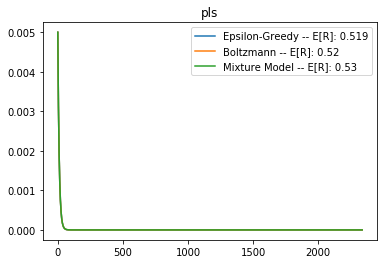

In [275]:
plot_convergence( Trivial(), _agent = particle_agent, plot_title = "pls" )

In [ ]:
plot_convergence( GridWorld(), plot_title = "Existing RL Agents on a Stationary Gridworld" )
plot_convergence( GridWorld(), _agent = linear_agent, plot_title = "Novel RL Agents on a Stationary Gridworld" )

plot_convergence( NonStationary(), plot_title = "Existing RL Agents on a Non-Stationary Gridworld")
plot_convergence( NonStationary(), _agent = linear_agent, plot_title = "Novel RL Agents on a Non-Stationary Gridworld" )

## P-Values of the Novel Agent(s)

In [ ]:
_agent = linear_agent( epsilon_greedy )
_agent.play( GridWorld() )


q_values = [[ _agent.q_value( (x, y), _agent.max_action((x, y), 0), 0 ) for x in range(25) ] for y in range(25) ]
plt.imshow( q_values, cmap = "hot")
plt.show()

In [ ]:
_agent = linear_agent( epsilon_greedy )
_agent.play( NonStationary( dynamic = independent ) )

q_values = [[ _agent.q_value( (x, y), _agent.max_action((x, y), 0), 0 ) for x in range(25) ] for y in range(25) ]
plt.imshow( q_values, cmap = "hot")
plt.show()

q_values = [[ _agent.xis[(x, y)] for x in range(25) ] for y in range(25) ]
plt.imshow( q_values, cmap = "hot")
plt.show()

In [ ]:
def sigmoid(x, rho = 1):
    return (np.exp(rho * x) / (1 + np.exp(rho * x)))

plt.plot( range(-11, 11), [ sigmoid(i) for i in range(-11, 11) ] )
plt.show()

In [ ]:
class inhomogenous_agent(agent):
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, rhos = (1, 1), lags = -1 ):
        super().__init__( action_selection, alpha, discount )

        self.rho1, self.rho2 = rhos
        self.TDES, self.L = [], lags
            
    def action_selection(self, state, randomness = None):
        return super().action_selection(state, self.distribution(state))
    
    def update(self, state, next_state, action, reward, time):
        delta = super().update( state, next_state, action, reward, time )
        self.TDES.append(delta)
        
        if self.L > -1 and len(self.TDES) > self.L:
            self.TDES.pop(0)
        return delta
    
    def phi_explore(self, state):
        state_len = len(self.q_vals) + 1
        state_sum = np.sum([ self.v_vals[i] for i in self.v_vals ]) + 1
        return sigmoid((1 / state_len) - ( self.v_vals[state] / state_sum ), self.rho1)
    
    def phi_exploit(self, state):
        relative = self.TDES[-1] / np.sum(self.TDES)
        return sigmoid(1 - (relative * len(self.TDES)), self.rho2)

    def distribution(self, state):
        epsilon = self.phi_exploit(state)
        return epsilon / (epsilon + self.phi_explore(state))

In [ ]:
_agent = inhomogenous_agent( mixture )
r, i, t = _agent.play( space )

print(r, i)
difference = [ (min(* state) / (max(* state) + 1)) - _agent.xis[(state, action)] for state, action in _agent.xis ]
print( np.sqrt( np.mean( np.array(difference) ** 2 ) ) )

plt.plot(range(i), t)
plt.show()

In [ ]:
difference = [ (1 - _agent.xis[(state, action)]) / ((min(* state) + 1) / (max(* state) + 1)) for state, action in _agent.xis ]
np.mean( difference )

In [ ]:
from itertools import product
from random import sample

alpha = discount = density = np.arange(0.1, 1, 0.1)
size, density = np.arange(5, 25, 5), np.arange(0.1, 1, 0.1)

parameters = list( product(alpha, discount, size, density) )
parameters = sample( parameters, len(parameters) // 10 )

In [ ]:
from tqdm import tqdm
import ray

@ray.remote
def run_scenario(strategy, parameter_set, inhomogenous):
    size, density = parameter_set.pop(2), parameter_set.pop(2)
    current_grid = Grid(size, reward_func = density_xor(density))
    
    current_agent = inhomogenous_agent(strategy, *parameter_set) if inhomogenous else agent(strategy, *parameter_set)
    rewards, iterations = current_agent.play( current_grid )
    return [ rewards, iterations ]
    
def test_agent(strategy, inhomogenous = False):
    agent_parameters = product( np.arange(0, 10, 0.5), np.arange(0, 10, 0.5), range(-1, 10) ) if inhomogenous else product( np.arange(0.1, 1, 0.1) )
    total_parameters = [ [*a, *b] for a, b in product( parameters, agent_parameters ) ]
    
    scenario = lambda x: run_scenario.remote(strategy, x, inhomogenous)
    results  = [ scenario(x) for x in tqdm(total_parameters) ]
    results  = ray.get( results )
    
    exogenous  = np.array( total_parameters, dtype = np.float32 )
    endogenous = np.array( results, dtype = np.float32 )

    endo_filename = descriptor + 'inhomogenous_endo.npy' if inhomogenous else '_endo.npy'
    exog_filename = descriptor + 'inhomogenous_exog.npy' if inhomogenous else '_exog.npy'

    np.save(endo_filename, endogenous)
    np.save(exog_filename, exogenous)
    
    gc.collect()

In [ ]:
ray.init()

for strategy in action_selection_strategies:
    test_agent(strategy, pool)
    test_agent(strategy, pool, True)

In [ ]:
import numpy
B = numpy.arange(0.025, 0.2525, 0.025)
[ a for a in B  ]
B

In [ ]:
def B(d1, d2):
    assert len(d1) == len(d2)
    return sum([ np.sqrt(d1[i] * d2[i]) for i in range(len(d1)) ])

def KL(d1, d2):
    assert len(d1) == len(d2)
    return sum([ d1[i] * np.log( d1[i] / d2[i] ) for i in range(len(d1)) ])

def normalize(d):
    d = d + abs(min(d))
    return [ i / sum(d) for i in d ]

def RMSE_q_values(agent, state):
    q_values = [ agent.q_vals[( state, a)] for a in agent.grid.actions(state) ]
    
    next_state = [ agent.grid.transition(state, a)[1] for a in agent.grid.actions(state) ]
    true_rwrds = [ ((x * y) + (x - 25)) / 25 for x, y in next_state ]
    
    return np.linalg.norm(np.array(q_values) - np.array(true_rwrds))

def RMSE_total(agent):
    return np.sqrt(np.mean([ RMSE_q_values(agent, (i, j)) for i in range(agent.grid.edge) for j in range(agent.grid.edge) ]))

In [ ]:
X, Y, Z, T = [], [], [], []

N = 1000
f = B #KL

for epsilon in tqdm(range(1, 11)):
    beta = epsilon / 10
    a, b, c = 0, 0, 0
    
    for i in range(N):
        rand_vec = np.random.random( 25 * 25 )
    
        boltz = np.exp(rand_vec * beta)/np.sum(np.exp(rand_vec * beta))
        mixy  = (1 - beta) *  np.exp(rand_vec)/np.sum(np.exp(rand_vec)) + (beta) * 1 / (rand_vec.shape[0])
        greed = (1 - beta) * (rand_vec == max(rand_vec)).astype("int")  + (beta) * 1 / (rand_vec.shape[0])
        
        a = a + f(boltz, mixy)
        b = b + f(boltz, greed)
        c = c + f(mixy, greed)

    X += [(10 - epsilon) / 10]
    Y += [a / N]
    Z += [b / N]
    T += [c / N]

plt.plot(X, Y, "g")
plt.plot(X, Z, "r")
plt.plot(X, T, "b")
plt.show()

In [ ]:
np.random.seed(1)
N = 4

def example_matrix(size):
    M = np.random.randint(0, 10, (size, size))
    M = M / M.sum(axis = 0)[np.newaxis, :]
    return M

def random_matrix(size):
    M = np.random.normal(size = (size, size))
    M = M / np.linalg.norm(M)
    return M

M = example_matrix(N)

In [ ]:
TRIALS = 20000

data = [ (np.eye(1, N, np.random.choice(N)).T, np.random.randint(100)) for i in tqdm(range(TRIALS)) ]

result = [ np.linalg.matrix_power(M, t).dot(d).reshape(N,) for d, t in data ]
result = [ np.eye(1, N, np.random.choice(N, p = r)).T for r in result ]

In [ ]:
def sample(M, previous, end, turns):
    probabilities = [ np.eye(1, N, i).T for i in range(N) ]    
    probabilities = [ x.T.dot( M.dot(previous) ) * end.T.dot( np.linalg.matrix_power(M, turns).dot(x) ) for x in probabilities ]
    
    probabilities = [ float(p) for p in probabilities]
    probabilities = [ p / sum(probabilities) for p in probabilities ]

    p = np.random.choice( range(N), p = probabilities)
    return np.eye(1, N, p).T, p
    
def interpolate(sampled):
    M = np.zeros(( N, N ))
    for i in range( 1, len(sampled) ):
        M[ sampled[i - 1], sampled[i] ] += 1
    M = M / ( len(sampled) - 1 )
    return M
    
def update(M, start, end, turns, alpha):
    sampled, previous = [ np.argmax(start) ], start
    for i in range(1, turns):
        previous, p = sample(M, previous, end, turns - i)
        sampled.append( p )
    
    sampled.append( np.argmax(end) )
    
    M = interpolate(sampled) + (alpha * M)
    M = M / M.sum(axis = 0)[np.newaxis, :]
    return M

In [ ]:
T = np.random.uniform(0, 1, size = (N, N))
T = T / T.sum(axis = 0)[np.newaxis, :]
print(T)

distances = []
for i in tqdm(range(TRIALS)):
    T = update( T, data[i][0], result[i], data[i][1], i )
    distances.append( np.linalg.norm(T - M) )
    
plt.plot( range(TRIALS), distances )
plt.show()

abs(T - M)

In [ ]:
a = np.random.normal(size = 10)
b = a / np.linalg.norm(a)

np.linalg.norm(0.11115 * b)

In [ ]:
[ np.eye(1, 4, i) for i in range(4) ]

In [ ]:
M = np.eye(4) * 3
a = np.eye(1, 4, 1).T

In [ ]:
M.dot(a), a